# Number recognition project

The purpose of this project is to use PyTorch to create a Conventional Neural Network (CNN) model to identify the number written in an image. The model would be created using a Modified National Institute of Standards (MNIST) dataset containing images with numbers 0 to 9 written on them. Lastly, to test the model further I will use images I made myself using a Windows application called Paint  to see if the model can correctly identify the numbers given.

## Import

In [20]:
pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [21]:


from load_model import *

## MLflow setup

In [22]:
mlflow.set_experiment("MNIST_Experiment")

# IMPORTANT: Enable system metrics monitoring
mlflow.config.enable_system_metrics_logging()
mlflow.config.set_system_metrics_sampling_interval(10)

## Data preparation


This section of code obtains the numbered MNIST dataset and preprocesses it so it is ready to be used for the neural network task.

In [23]:
# create data transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# download datasets
mnist_train = datasets.MNIST(
    root='/content',
    train=True,
    download=True,
    transform=transform
)

mnist_test = datasets.MNIST(
    root='/content/',
    train=False,
    download=True,
    transform=transform
)

# create dataLoaders
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True,num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False,num_workers=4, pin_memory=True)

In [24]:
len(mnist_train.classes)# classes are numbers 0-9

10

In [25]:
# get one batch
images, labels = next(iter(train_loader))

c:\Users\joelb\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


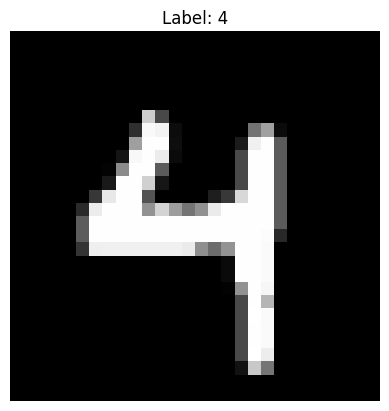

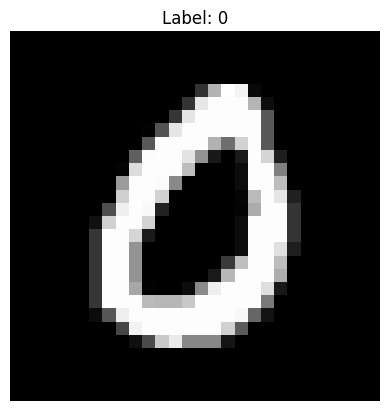

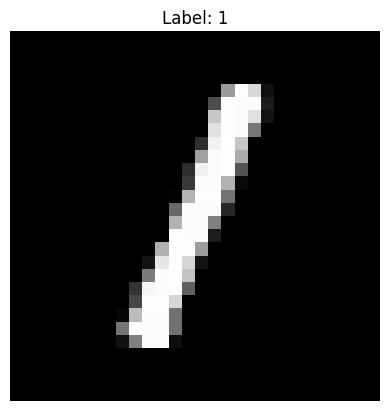

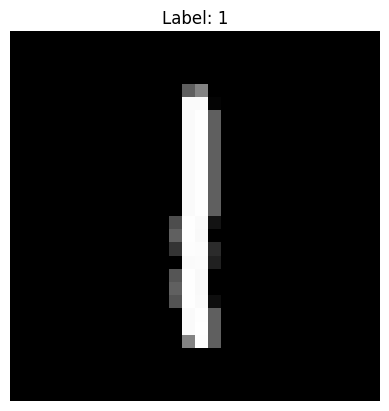

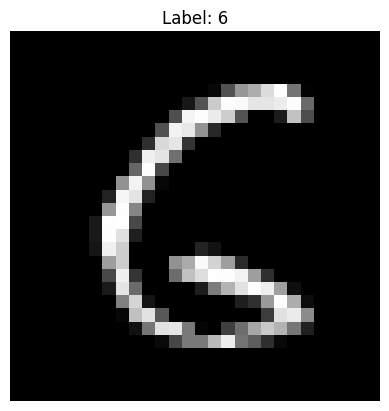

In [26]:
# view first 5 images in batch
for i in range(0,5):
  plt.imshow(images[i].squeeze(), cmap='gray')
  plt.title(f"Label: {labels[i].item()}")
  plt.axis('off')
  plt.show()

In [27]:
print(images.shape)

torch.Size([64, 1, 28, 28])


## Model creation



In creating the CNN model, the first thing made is the feature extraction layers. These layers are to extract important features/patterns from the input image.
Next, it then uses these in the fully connected layers to identify the number in the image.

In [28]:
# model creation has been moved to seperate load_model.py

## Model training

The model would be trained for up to 10 epochs (how many times it goes through the training data). I am tracking the accuracy as well as the training and validation loss of each epoch. Loss measures how far off the model’s predictions are from the actual target values. Accuracy is the percentage of correct predictions out of total predictions. <br><br>
The training process will stop if there is no improvement in its accuracy after 3 epochs in a row.

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")# use gpu instead of cpu for processing
model = CNN().to(device)# create cnn model

In [30]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)# optimizer (Adam) for model parameter updates
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=1)# reduces learning rate if validation accuracy plateaus
criterion = nn.CrossEntropyLoss()# loss function for multi-class classification

In [31]:
#after running use 'mlflow ui' in terminal on the same directory as file to open results at http://localhost:5000/
n_epochs = 10
epochs_without_improvement = 0
patience = 3 # stop after this many epochs without improvement
# training metrics
best_accuracy = 0.0
cost_list = []# stores training loss per epoch
accuracy_list = []  # stores validation accuracy per epoch
with mlflow.start_run() as run:
    # log training parameters
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 64)

    # create a signature to log with best model (so API know what to expect)
    input_example = next(iter(train_loader))[0][0:1].numpy() 
    prediction_example = model(torch.tensor(input_example).to(device)).detach().cpu().numpy()
    signature = infer_signature(input_example, prediction_example)

    # tags for Searchability
    mlflow.set_tag("model_type", "CNN")
    mlflow.set_tag("dataset", "MNIST")

    for epoch in range(n_epochs):
        model.train() # set model to training mode
        running_loss = 0.0

        #train model
        for x, y in train_loader:# iterate over mini-batches from training data
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)#move data to gpu/cpu

            optimizer.zero_grad(set_to_none=True)#reset gradients before backward pass

            outputs = model(x)# forward pass: compute model outputs
            loss = criterion(outputs, y)# compute loss between outputs and ground truth

            loss.backward()# backward pass: compute gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)#clip gradients to prevent exploding gradients
            optimizer.step()# update model parameters

            running_loss += loss.item()


        model.eval()# set model to evaluation mode
        correct = 0
        total = 0
        val_loss = 0.0

        # validate model
        with torch.no_grad():#prevent gradient calulation
            for x_test, y_test in test_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)#move validation data to device
                outputs = model(x_test)# forward pass
                loss = criterion(outputs, y_test)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += y_test.size(0)
                correct += (predicted == y_test).sum().item()

        # calculate average training and validation loss for this epoch
        epoch_loss = running_loss / len(train_loader)
        val_loss = val_loss / len(test_loader)

        accuracy = correct / total
        
        scheduler.step(accuracy)
        #save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_without_improvement += 1
            #end training early if no improvement after 3 epochs in a row
            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break

        cost_list.append(epoch_loss)
        accuracy_list.append(accuracy)
        # Track metrics in MLflow instead of just local lists
        mlflow.log_metric("epoch_loss", epoch_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("accuracy", accuracy, step=epoch)
        print(f'Epoch [{epoch+1}/{n_epochs}]')
        print(f'Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Accuracy: {accuracy:.4f}')
    #log best model
    model.load_state_dict(torch.load('best_model.pth'))       
    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path="mnist_cnn_model",
        registered_model_name="MNIST_Production_Model", 
        signature=signature,
        input_example=input_example
)

2026/01/01 17:35:50 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2026/01/01 17:35:50 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch [1/10]
Train Loss: 0.1176 | Val Loss: 0.0459 | Accuracy: 0.9850
Epoch [2/10]
Train Loss: 0.0436 | Val Loss: 0.0313 | Accuracy: 0.9903
Epoch [3/10]
Train Loss: 0.0321 | Val Loss: 0.0307 | Accuracy: 0.9907
Epoch [4/10]
Train Loss: 0.0248 | Val Loss: 0.0233 | Accuracy: 0.9925
Epoch [5/10]
Train Loss: 0.0197 | Val Loss: 0.0291 | Accuracy: 0.9909
Epoch [6/10]
Train Loss: 0.0157 | Val Loss: 0.0274 | Accuracy: 0.9925
Epoch [7/10]
Train Loss: 0.0060 | Val Loss: 0.0183 | Accuracy: 0.9944
Epoch [8/10]
Train Loss: 0.0037 | Val Loss: 0.0172 | Accuracy: 0.9950
Epoch [9/10]
Train Loss: 0.0027 | Val Loss: 0.0177 | Accuracy: 0.9951


2026/01/01 17:44:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [10/10]
Train Loss: 0.0023 | Val Loss: 0.0174 | Accuracy: 0.9954


Registered model 'MNIST_Production_Model' already exists. Creating a new version of this model...
Created version '2' of model 'MNIST_Production_Model'.
2026/01/01 17:44:23 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2026/01/01 17:44:23 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


### Training results

These results are ideal as it shows that after more epochs the accuracy increases and the cost (epoch loss) decreases. This means that the model should perform well in its task.

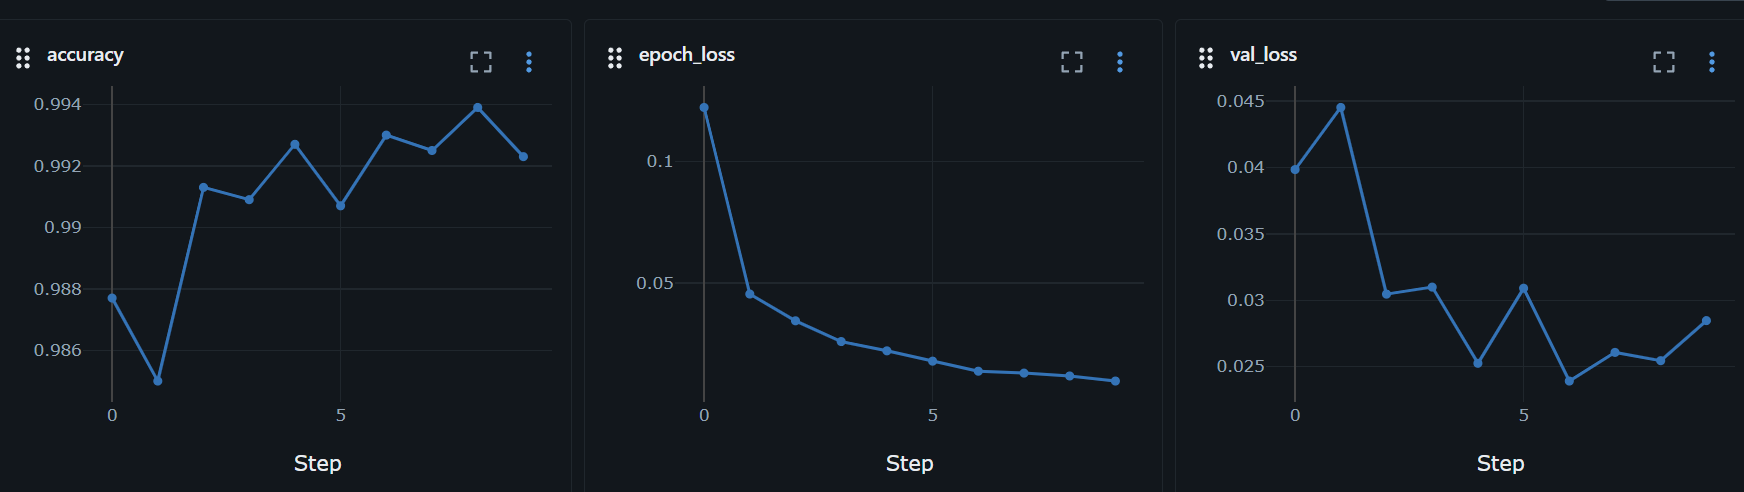

## Test Paint images

To further test the model, I have written used the Paint application to create three images with numbers 1,5 and 7 written on them. In order to apply the model to classify them, they must first be preprocessed to match the format of the MNIST dataset numbers.<br><br>
In the results, you will see the:
* The preprocessed image (what the model sees)
* Then the original image and what the model classified it as

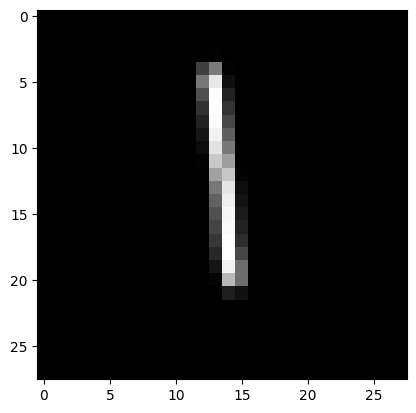

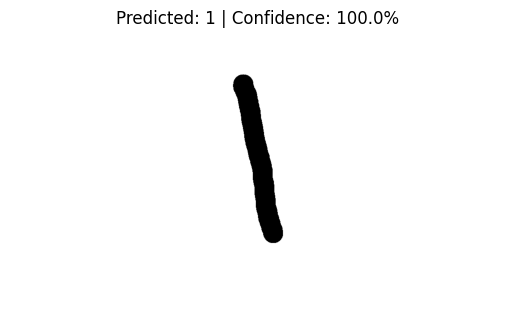

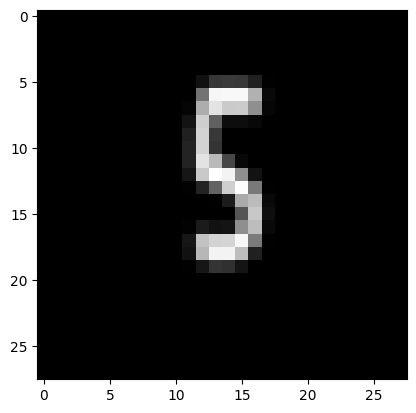

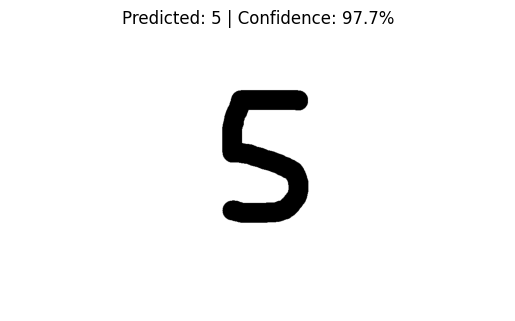

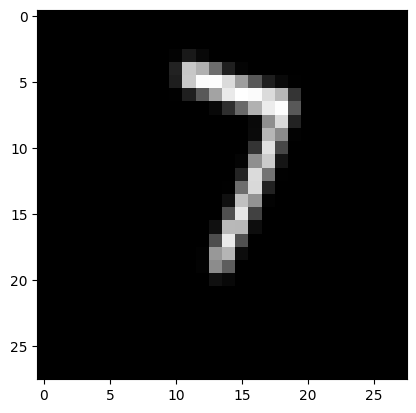

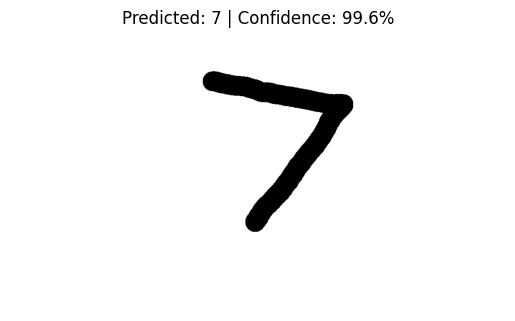

In [33]:
# load best trained model
best_model =get_best_model()


#new transform so new data matches format of train/test data
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.functional.invert,
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

def predict_digit(image_path):
    # load and preprocess image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # add batch dimension
    plt.imshow(image.squeeze(), cmap='gray')#show new preprocessed image
    plt.show()

    # prediction
    with torch.no_grad():
        output = best_model(image)
        _, predicted = torch.max(output, 1)
        probabilities = torch.nn.functional.softmax(output, dim=1)

    return predicted.item(), probabilities.squeeze().tolist()

# Example usage
image_paths = ["../tests/num_1.png", "../tests/num_5.png", "../tests/num_7.png"]

for path in image_paths:
    prediction, probs = predict_digit(path)
    plt.imshow(Image.open(path), cmap='gray')#show original image
    plt.title(f"Predicted: {prediction} | Confidence: {probs[prediction]*100:.1f}%")
    plt.axis('off')
    plt.show()


## Conclusion


In conclusion, the project is a success as I have created a CNN model that can accurately classify number images. However, this project overall can be improved further if I were to attempt it again by:

* Adding the model to a webpage where users can draw a number on screen and the program will use the model to attempt to classify the number
* Training the model to be able to predict numbers outside the range 0-9